In [2]:
import numpy as np
import pandas as pd

PARTICIPANT_ID = 46

df_csv=pd.read_csv('/Users/apple/Desktop/deep_eye/dataset/input_data.csv',usecols=['participant_ID','Q_ID','text','fixation1'])
df_csv=df_csv[(df_csv['participant_ID']==PARTICIPANT_ID)] # take 1st participant data
df_csv=df_csv.drop(['participant_ID'],axis=1)
#df_csv=df_csv.fillna(' ')
df_csv

,Q_ID,text,fixation1
54945,1,兩,0
54946,1,個,0
54947,1,量筒,1
54948,1,各,0
54949,1,裝,1
...,...,...,...
56161,47,變化,1
56162,47,變大,0
56163,47,變小,0
56164,47,不會,0


In [3]:
list_data=[]
for j in range(1,48): #Q1~47
    df=df_csv[(df_csv['Q_ID']==j)][['text','fixation1']] # keep 'text' and 'fixation1' 
    mylist = np.array(df).tolist()
    list_data.append(mylist)

texts=[[j[0] for j in i]for i in list_data] # len(texts)=47 # 
labels=[[str(j[1]) for j in i]for i in list_data]
#print(labels)

In [11]:
from keras.preprocessing.text import Tokenizer
#tf.keras.preprocessing.text.Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = max(len(s) for s in texts) # word count in longest sentence #44
tokenizer = Tokenizer() # tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts) #https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/
sequences = tokenizer.texts_to_sequences(texts) # turn text to number
word_index = tokenizer.word_index #unique word to number
MAX_NB_WORDS = len(word_index)+1 # 372=total count of unique words  #372+1=373 

x = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)  # left padding #, padding='post'
y = pad_sequences(labels, MAX_SEQUENCE_LENGTH, dtype='int32', value=-1)  # left padding with -1
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=3) for i in y] # turn -1 -> [0,0,1], 0 -> [1,0,0], 1 -> [0,1,0] 
# https://blog.csdn.net/qq_31456593/article/details/89578018
# usually shape will be(num_samples,max_length), but crf layer needs shape to be (num_samples,max_length,1)
# therefore, expand 1 dimension with 'expand_dims'

# x = np.expand_dims(x, 2)
# y = np.expand_dims(y, 2) 


from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1, train_size=0.9, random_state=20220313)
print("train_x shape:", len(train_x))
print("train_y shape:", len(train_y))
print("test_x shape:", len(test_x))
print("test_y shape:", len(test_y))

ImportError: cannot import name 'GlobalOpDispatcher' from 'tensorflow.python.util.dispatch' (/Users/apple/Documents/ml_env/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py)

In [111]:
# # show current data form
# for text, label in zip(train_x[0], train_y[0]):
#     print('%s\t%s' % (text, label))

## Model Layout

- **Layer 1 - Embedding layer** : We will feed the padded sequences of equal length (44) to the embedding layer. Once the network has been trained, each token will get transformed into a vector of n dimensions. We have chosen the n dimensions to be (32). 


These are the dimensions (?, 44, 32) plotted in the model plot for input layer and embedding layer. The ? or None in the dimension specifies batches, when it is None or ? the model can take any batch size.

- **Layer 2 - Bidirectional LSTM** : Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer (44, 32). It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The default mode is to concatenate, where the outputs are concatenated together, providing double the number of outputs to the next layer, in our case its 64(32 * 2).


The output dimension of the bidirectional lstm layer (?, 44, 64) becomes the input dimension of the next lstm layer.

- **Layer 3 - LSTM Layer** : An LSTM network is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, the forget gate and the output gate.


This layer takes the output dimension from the previous bidirectional lstm layer (?, 44, 64) and outputs (?, 104, 128)


- **Layer 4 - TimeDistributed  Layer** : We are dealing with Many to Many RNN Architecture where we expect output from every input sequence for example (a1 →b1, a2 →b2… an →bn) where a and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow you to apply Dense(fully-connected) operation across every output over every time-step. If you don't use this, you would only have one final output.

This layer take the output dimension of the previous lstm layer (104, 128) and outputs the max sequence length (44) and max tags (3or2).

In [4]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from tensorflow.keras.utils import plot_model

In [5]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [10]:
input_dim = MAX_NB_WORDS #MAX_NB_WORDS = len(word_index)+1 # 372=total count of unique words  #372+1=373 
output_dim = 128

input_length = MAX_SEQUENCE_LENGTH # MAX_SEQUENCE_LENGTH = max(len(s) for s in texts) # word count in longest sentence #44
n_tags = 3 # 3 kinds of label
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  373 
output_dim:  128 
input_length:  44 
n_tags:  3


In [11]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)) #0.5

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    import keras as k
    adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
    #adam = k.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.5)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

# def train_model(x, y, model):
#     loss = list()
#     for _ in range(25):
#         # fit model for one epoch on this sequence
#         #hist = model.fit(x, y, batch_size=10, verbose=1, epochs=10, validation_split=0.3)
#         hist = model.fit(x, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
#         loss.append(hist.history['accuracy'][0])
#     return loss

model_bilstm_lstm = get_bilstm_lstm_model()
#plot_model(model_bilstm_lstm)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 44, 128)           47744     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 44, 256)           263168    
_________________________________________________________________
lstm_3 (LSTM)                (None, 44, 128)           197120    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 44, 3)             387       
Total params: 508,419
Trainable params: 508,419
Non-trainable params: 0
_________________________________________________________________


In [12]:
EPOCHS = 10
BATCH_SIZE = 5
train_history = model_bilstm_lstm.fit(train_x, np.array(train_y), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1)# ,  validation_data=(test_x, test_y))

Epoch 1/10
8/8 [==============================] - 8s 310ms/step - loss: nan - accuracy: 0.3754 - val_loss: nan - val_accuracy: 0.4727
Epoch 2/10
8/8 [==============================] - 2s 233ms/step - loss: nan - accuracy: 0.4030 - val_loss: nan - val_accuracy: 0.4727
Epoch 3/10
8/8 [==============================] - 2s 211ms/step - loss: nan - accuracy: 0.4510 - val_loss: nan - val_accuracy: 0.4727
Epoch 4/10
8/8 [==============================] - 2s 212ms/step - loss: nan - accuracy: 0.4635 - val_loss: nan - val_accuracy: 0.4727
Epoch 5/10
8/8 [==============================] - 2s 225ms/step - loss: nan - accuracy: 0.4243 - val_loss: nan - val_accuracy: 0.4727
Epoch 6/10
8/8 [==============================] - 2s 218ms/step - loss: nan - accuracy: 0.4330 - val_loss: nan - val_accuracy: 0.4727
Epoch 7/10
8/8 [==============================] - 2s 219ms/step - loss: nan - accuracy: 0.4251 - val_loss: nan - val_accuracy: 0.4727
Epoch 8/10
8/8 [==============================] - 2s 223ms/ste

In [13]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()

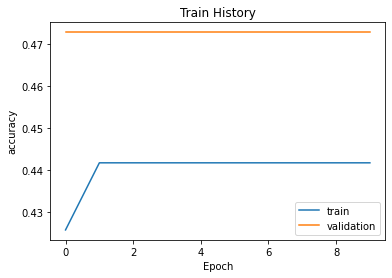

In [14]:
show_train_history(train_history,'accuracy','val_accuracy')

In [19]:
test_x[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 297,   2,
       182,  17, 183, 298,  20, 299,  72,  75,   2,  35,  35,   1, 179,
       300, 301,  25,  21,  59, 302,  42,  25, 183,   2,  35,   1,  25,
       182,   2,  35,   1,  25], dtype=int32)

In [20]:
test_x[0].reshape((-1,1))

array([[  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [297],
       [  2],
       [182],
       [ 17],
       [183],
       [298],
       [ 20],
       [299],
       [ 72],
       [ 75],
       [  2],
       [ 35],
       [ 35],
       [  1],
       [179],
       [300],
       [301],
       [ 25],
       [ 21],
       [ 59],
       [302],
       [ 42],
       [ 25],
       [183],
       [  2],
       [ 35],
       [  1],
       [ 25],
       [182],
       [  2],
       [ 35],
       [  1],
       [ 25]], dtype=int32)

In [24]:
model_bilstm_lstm.predict_classes(test_x[0]) # test_x[0].reshape((-1,1))

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [17]:
test_y[0]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [97]:

# from keras.layers.merge import concatenate
# from keras.layers.core import *
# from keras.layers.recurrent import LSTM
# from keras.models import *
# from keras.layers import Embedding, Bidirectional, LSTM,Dense, Conv1D, MaxPooling1D,TimeDistributed,Flatten

# INPUT_DIM = 1
# TIME_STEPS = MAX_SEQUENCE_LENGTH
# # if True, the attention vector is shared across the input_dimensions where the attention is applied.
# SINGLE_ATTENTION_VECTOR = False
# def attention_3d_block(inputs):
#     # inputs.shape = (batch_size, time_steps, input_dim)
#     input_dim = int(inputs.shape[2])
#     a = Permute((2, 1))(inputs)
#     a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
#     a = Dense(TIME_STEPS, activation='softmax')(a)
#     if SINGLE_ATTENTION_VECTOR:
#         a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
#         a = RepeatVector(input_dim)(a)
#     a_probs = Permute((2, 1), name='attention_vec')(a)
#     output_attention_mul = concatenate([inputs, a_probs], name='attention_mul')
#     return output_attention_mul

# def model_attention_applied_after_lstm():
#     inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
#     lstm_units = 22
#     lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
#     attention_mul = attention_3d_block(lstm_out)
#     # attention_mul = Flatten()(attention_mul)
#     output = Dense(1, activation='sigmoid')(attention_mul)
#     model = Model([inputs], output) #model = Model(input=[inputs], output=output)
#     return model

# def model_attention_applied_before_lstm():
#     inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
#     attention_mul = attention_3d_block(inputs)
#     lstm_units = 32
#     attention_mul = LSTM(lstm_units, return_sequences=True)(attention_mul)#原例子中是return_sequences=False
#     output = Dense(1, activation='sigmoid')(attention_mul)
#     model = Model([inputs], output)# model = Model(input=[inputs], output=output)
#     return model

# model = model_attention_applied_after_lstm()
# #model = model_attention_applied_before_lstm()

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print(model.summary())

# # m.fit([inputs_1], outputs, epochs=1, batch_size=64, validation_split=0.1)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 44, 1)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 44, 22)       2112        input_4[0][0]                    
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 22, 44)       0           lstm_3[0][0]                     
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 22, 44)       0           permute_3[0][0]                  
____________________________________________________________________________________________

In [98]:
EPOCHS = 10


# train model
train_history=model.fit(train_x, train_y,batch_size=4,epochs=EPOCHS,  validation_data=(test_x, test_y))
# original validation_data is [], change to ()
# train_history=model.fit(train_x, train_y,batch_size=4,epochs=EPOCHS,  validation_data=[test_x, test_y])

model.save('model/crf.h5')

Epoch 1/10
11/11 [==============================] - 3s 99ms/step - loss: 0.7070 - accuracy: 0.3444 - val_loss: 0.6937 - val_accuracy: 0.2318
Epoch 2/10
11/11 [==============================] - 0s 28ms/step - loss: 0.6624 - accuracy: 0.3453 - val_loss: 0.5755 - val_accuracy: 0.2318
Epoch 3/10
11/11 [==============================] - 0s 27ms/step - loss: 0.5758 - accuracy: 0.3397 - val_loss: 0.3761 - val_accuracy: 0.2318
Epoch 4/10
11/11 [==============================] - 0s 23ms/step - loss: 0.4234 - accuracy: 0.3755 - val_loss: -0.1006 - val_accuracy: 0.2318
Epoch 5/10
11/11 [==============================] - 0s 26ms/step - loss: 0.0595 - accuracy: 0.3342 - val_loss: -0.6722 - val_accuracy: 0.2318
Epoch 6/10
11/11 [==============================] - 0s 23ms/step - loss: -0.3915 - accuracy: 0.3214 - val_loss: -1.1583 - val_accuracy: 0.2318
Epoch 7/10
11/11 [==============================] - 0s 24ms/step - loss: -0.7119 - accuracy: 0.3445 - val_loss: -1.5838 - val_accuracy: 0.2318
Epoch 8

In [100]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()


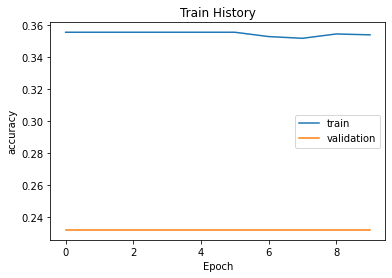

In [101]:
show_train_history(train_history,'accuracy','val_accuracy')

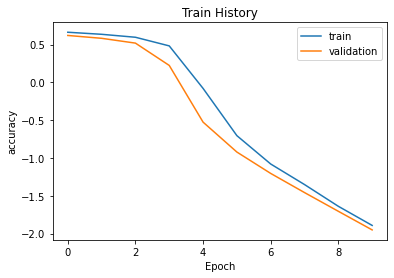

In [25]:
show_train_history(train_history,'loss','val_loss')